# Portuguese Vocabulary Exercises
### Project by Thomas Lindstrom-Vautrin
Learning languages is a hobby of mine. One of the languages I have taken an interest in is Portuguese. As I have been learning, I have tried to find ways to make that learning more effective. My goal with this project is simply to have a place to train on Portuguese vocabulary as I continue to learn the language. The main feature I will implement is a means of extracting relevant vocabulary from Portuguese text copied and pasted from any online source. In particular, when watching a Portuguese language show on Netflix, I want to be able to copy and paste the Portuguese subtitles into this program and extract the most relevant vocabulary terms so that I can anticipate them before watching an episode. But this extends also to news articles I may read in Portuguese, or chapters I read in e-books... Any Portuguese text should work.

## Setting Up
Here we install and import all the necessary packages. Originally I used the Google Translate package instead of performing my own machine translation, since the main thrust of this project is identifying relevant vocabulary and not translating that vocabulary, but this package became unreliable. Instead I decide not to translate words at all and simply provide sentences which may contain them, based on data we already have.

In [ ]:
import os
import glob
import re
from collections import Counter
import random
import pickle

import numpy as np
import pandas as pd

from IPython.display import clear_output

from scipy.stats import arcsine
from scipy.stats import beta
import matplotlib.pyplot as plt

In preparing for this project, I referenced the following notebook: https://medium.com/dair-ai/neural-machine-translation-with-attention-using-pytorch-a66523f1669f

Some code has been adapted from that notebook, and we use data from the same original source: http://www.manythings.org/anki/

In the following code we import and clean the Portuguese phrases which we use as a basis for our program.

In [52]:
lines = open('data/por.txt', encoding='UTF-8').read().strip().split('\n')

original_phrases = [[p for p in l.split('\t')] for l in lines]

data = pd.DataFrame(original_phrases, columns=["eng", "pt", "other"])
del(data["other"])

Index(['eng', 'pt'], dtype='object')


In [5]:
data

,eng,pt
0,Go.,Vai.
1,Go.,Vá.
2,Go.,ir.
3,Hi.,Oi.
4,Run!,Corre!
...,...,...
157970,I recommend contributing sentences in your own...,Eu recomendo contribuir com frases em seu próp...
157971,I recommend contributing sentences in your own...,Recomendo que você contribua com frases em seu...
157972,No matter how much you try to convince people ...,Não importa o quanto você tenta convencer os o...
157973,Some movies make such an impact that one never...,Alguns filmes são tão marcantes que jamais nos...


In [6]:
# Transform a sentence into a string of space-separated words without punctuation.
def words_only(w):
    # These characters have been identified as the Portuguese-language word-forming characters in our dataset.
    w = re.sub(r"[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ]+", " ", w)
    
    w = w.strip()
    
    return w

# Transform a sentence into a string of space-separated words with space-separated "final punctuation".
def final_punctuation(w):
    # Add a space before and after "final punctuation".
    # "Final punctuation" is defined as punctuation which either ends a sentence or begins a quotation.
    # In either of these cases the following character is likely to be capitalized even if the word is not
    # a named entity, which is relevant for rudimentary identification of named entities.
    w = re.sub(r'([?.!\'"])', r" \1 ", w)
    w = re.sub(r'[ ]+', " ", w)
    
    w = re.sub(r'[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ?.!\'"]+', " ", w)
    
    w = w.strip()
    
    return w

# Extracted from "NMT in PyTorch" tutorial.
# https://medium.com/dair-ai/neural-machine-translation-with-attention-using-pytorch-a66523f1669f
def preprocess_sentence(w, context=1):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r'([?.!,])', r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except the existing acceptable characters and ".", "?", "!", ","
    w = re.sub(r"[^oeasrmiuntdclpvqThãfEgêbáézVOjNAçMóPxQíySCDàIFBÉúHJôGUõLâkRwKÀYÁWXÍZÓÂ?.!,]+", " ", w)
    
    w = w.strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    for i in range(context):
        w = '<start> ' + w + ' <end>'
    return w

## Rudimentary Named Entity Recognition
It will be useful to identify words which are named entities and do not constitute typical words in the vocabulary. We will use the simple heuristic that a word which is capitalized in the middle of a sentence is most likely a named entity.

In [7]:
# A rudimentary approach to named entity recognition:
# Identify non-lowercase words in parts of the phrase which are not the beginning of the sentence
# or after "final punctuation".

fin_punct = ['?', '.', '!', "'", '"']

# Identify all words in the corpus, including different capitalizations.
all_words = set()
for phrase in data["pt"]:
    all_words.update(words_only(phrase).split(' '))

# Perform a rudimentary form of named entity recognition.
# Identify capitalized words which are not at the beginning of a sentence.
def rudimentary_NER(phrases=data["pt"], vocab=all_words):
    named_entities = set()

    for phrase in phrases:
        phrase_words = words_only(phrase).split(' ')
        phrase = final_punctuation(phrase).split(' ')
        for i in range(len(phrase)):
            # If the word is indeed a word and not punctuation and if the word is not all lowercase...
            if phrase[i] not in fin_punct and phrase[i] != phrase[i].lower():
                # If the word is not the first word and does not follow "final punctuation"...
                if phrase[i] != phrase_words[0] and phrase[i-1] not in fin_punct:
                        named_entities.add(phrase[i]) # This is a named entity.
                # If it does have an excuse to be capitalized...
                else:
                    # Check if it has an all lowercase form in the vocabulary...
                    if phrase[i].lower() not in all_words:
                        named_entities.add(phrase[i])
    
    return named_entities

named_entities = rudimentary_NER()

In [8]:
# Remove the two most obvious incorrectly identified named entities
named_entities.remove('A') # feminine equivalent of "the"
named_entities.remove('O') # masculine equivalent of "the"

Now we proceed to create a list of vocabulary extracted from the phrases.

In [9]:
count = Counter()

# Get the counts for each word, treating named entities seperately.
# We do not remove named entities so that they can still be used in sentence production.
for phrase in data["pt"]:
    for word in words_only(phrase).split(' '):
        if word in named_entities:
            count[word] += 1
        else:
            count[word.lower()] += 1

# Define the vocabulary as the words ordered by count. Keep track of these counts also.
vocab = [w for w, c in sorted(count.items(), key=lambda x: x[1], reverse=True)]
count = [c for w, c in sorted(count.items(), key=lambda x: x[1], reverse=True)]

# Get the frequencies from the counts.       
total_count = sum(count)
freq = [c/total_count for c in count]

# Identify the indices of the named entities. We don't need to know which is which.
named_entity_indices = set()
for index, word in enumerate(vocab):
    if word in named_entities:
        named_entity_indices.add(index)    

Here we match each word to the phrases containing it. The following code is commented out because it only needs to be performed once. We then proceed to save the data, and then reload it since it takes some time to generate this data.

In [10]:
def initialize_words_to_phrases():
    # For each word, get all the phrases which contain it.
    phrase_words = [[word if word in named_entities else word.lower() for word in words_only(phrase).split(' ')] for phrase in data["pt"]]
    words_to_phrases = {}
    for i in range(len(phrase_words)):
        for word in phrase_words[i]:
            if word in words_to_phrases.keys():
                words_to_phrases[word].append(data["pt"][i])
            else:
                words_to_phrases[word] = [data["pt"][i]]

    pickle_out = open("words_to_phrases.pickle", "wb")
    pickle.dump(words_to_phrases, pickle_out)
    pickle_out.close()

In [11]:
pt2en_phrases = {}
for i in range(len(data["pt"])):
    pt2en_phrases[data["pt"][i]] = data["eng"][i]

In [12]:
pickle_in = open("words_to_phrases.pickle", "rb")
words_to_phrases = pickle.load(pickle_in)
words_to_phrases['vai']

['Vai.',
 'Vai-te embora!',
 'Vai para dentro.',
 'Como vai o Tom?',
 'Tom vai.',
 'A gente vai tentar.',
 'Quem vai?',
 'Como vai o Tom?',
 'Isso vai funcionar.',
 'Vai funcionar.',
 'Isso vai servir.',
 'Tom vai chorar.',
 'Tom vai morrer.',
 'Vai encontrar Tom.',
 'Vai achar o Tom.',
 'Vai para casa agora.',
 'Vai por ali.',
 'Como vai?',
 'Como vai você?',
 'Vai ficar tudo bem.',
 'Tom vai vir.',
 'Tom vai saber.',
 'Tom vai perder.',
 'Tom vai ficar.',
 'Tom vai falar.',
 'Tom vai esperar.',
 'A gente vai compartilhar.',
 'Quem vai cozinhar?',
 'Ele vai morrer?',
 'Você vai?',
 'Você vai perder.',
 'Vai à escola.',
 'Ele vai caminhar.',
 'Como vai a escola?',
 'Vai queimar.',
 'Isso vai queimar.',
 'Vai funcionar.',
 'Isso vai acontecer.',
 'Isso vai ajudar.',
 'Isso vai ajudar.',
 'Isso vai funcionar.',
 'Tom vai chorar.',
 'Tom vai morrer.',
 'Tom vai pagar.',
 'Tom vai tentar.',
 'Tom vai vencer.',
 'Tom vai falar.',
 'Quem vai pagar?',
 'Quem vai ganhar?',
 'Quem vai dirigir?'

## Storing a User's Vocabulary Knowledge
We want to maintain a database representing how familiar a given user is with a given word. Let us say that a user can be completely unfamiliar with a word (let's call this 0% familiar), or completely familiar with a word (let's call this 100% familiar). Let us also assume that the average user will be more familiar with words which occur more frequently. In the following "scale_frequency" function, we define a method of transforming the frequency of each word into a level of familiarity with each word.

In [13]:
# Define a scaled frequency which represents the familiarity of the user with each word as a percentage.
def scale_frequency(freq=freq, n=None, level="functional"):
    num = 1
    if not n:
        # Beginner: first 100 words have minimum 50% familiarity
        if level == "beginner":
            num = 100
        # Functional: first 500 words have minimum 50% familiarity 
        elif level == "functional":
            num = 500
        # Conversational: first 1000 words have minimum 50% familiarity
        elif level == "conversational":
            num = 1000
        # Advanced: first 4000 words have minimum 50% familiarity
        elif level == "advanced":
            num = 4000
        # Fluent: first 10000 words have minimum 50% familiarity
        elif level == "fluent":
            num = 10000
    else:
        num = n
        
    # This scales the whole list so that the num-th word has probability 0.5.
    # Tanh behaves in such a way that numbers in [0,1] stay more or less themselves,
    # whereas numbers much larger than zero are squashed into the interval [0,1].
    return np.tanh((0.5/freq[num-1])*np.array(freq)).tolist()

In [14]:
package

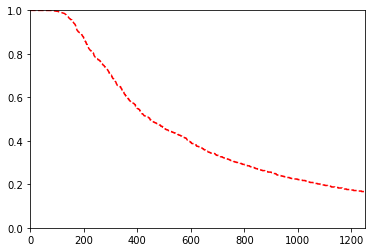

In [15]:
# Visualize probability distribution
x = np.linspace(0, len(vocab), len(vocab))
y = scale_frequency()

plt.ylim(top=max(y), bottom=0)
plt.xlim(left=0, right=1.25*1000)
plt.plot(x, y, "r--")

In the following cells, we manage the data stored for different users of the program.

## Managing Exercise Difficulty
In order to control the difficulty of the exercises presented to the user, we will choose words with different levels of familiarity with different probabilities. In other words, at a medium difficulty level, we want to focus on 50% familiarity words, so that high familiarity and low familiarity words are less likely to show up than words of moderate familiarity, words which are at the cusp of being known. We use a beta distribution over [0,1] to get this effect.

In [16]:
def get_distribution(arr, m=0.5, inv_v=0.05, flatness=0.01):
    if flatness >= 1:
        return np.ones(len(arr)).tolist()
        
    a = m/inv_v; b = (1 - m)/inv_v
    distr = beta.pdf(arr, a, b)
    
    if flatness <= 0:
        return distr
    
    upper = max(distr)
    integral = sum(distr)
    baseline = (upper/((1/flatness)-1))*np.ones(len(arr))
    new_integral = integral + sum(baseline)
    return (distr + baseline)*(integral/new_integral)

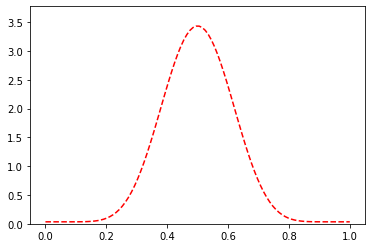

In [17]:
# Visualize probability distribution
x = np.linspace(0, 1.0, 100)
y = get_distribution(x)

plt.ylim(top=1.1*max(y), bottom=0)
plt.plot(x, y, "r--")

## Updating Knowledge
Every time an exercise is undertaken, we need to increase the familiarity of a word which is correctly identified, and decrease the familiarity of a word which is incorrectly identified.

In [18]:
# lr = learning rate; fr = forgetting rate
def update(arr, index, correct, lr=0.3, fr=0.3):
    if correct:
        # Increase its probability
        arr[index] += (1-arr[index])*lr
    else:
        # Decrease its probability
        arr[index] -= arr[index]*fr

## Managing Users

In [19]:
def initialize_users():
    users = {}
    users["Default"] = scale_frequency()
    pickle_out = open("users.pickle", "wb")
    pickle.dump(users, pickle_out)
    pickle_out.close()

In [20]:
pickle_in = open("users.pickle", "rb")
users = pickle.load(pickle_in)
current_user = "Default"
user_levels = ["beginner", "functional", "conversational", "advanced", "fluent"]

# Changes the current user
def change_user(user):
    global current_user
    if user in users.keys():
        current_user = user
        return True
    else:
        print('This user name does not exist.')
        return False

# Add a new user
def add_user(user, distr=freq, n=None, level="functional"):
    global users
    global current_user
    if user not in users.keys():
        if level in user_levels:
            current_user = user
            users[user] = scale_frequency(freq=distr, n=n, level=level)

            # Save changes.
            pickle_out = open("users.pickle", "wb")
            pickle.dump(users, pickle_out)
            pickle_out.close()

            # Update local version of users.
            pickle_in = open("users.pickle", "rb")
            users = pickle.load(pickle_in)

            return True
        else:
            print('This is not a valid level.')
            return False
    else:
        print('This user name already exists.')
        return False
    
def delete_user(user):
    global users
    if user == current_user:
        print('Cannot delete current user.')
        return False
    if user not in users.keys():
        print('User does not exist.')
        return False
    else:
        del users[user]
                
        # Save changes.
        pickle_out = open("users.pickle", "wb")
        pickle.dump(users, pickle_out)
        pickle_out.close()

        # Update local version of users.
        pickle_in = open("users.pickle", "rb")
        users = pickle.load(pickle_in)
        
        return True
    
def list_users():
    print("+-----------+")
    print("| USER LIST |")
    print("+-----------+")
    max_user_ln = max([len(key) for key in users.keys()])
    max_level_ln = max([len(lvl) for lvl in user_levels])
    for user in users.keys():
        level = calculate_level(users[user])
        print('  '+user+':'+' '*(1+max_user_ln+max_level_ln-len(user)-len(level))+level)
    print()
    return

## Managing Snippets of Input Text
We save copied-and-pasted snippets of Portuguese text in bag-of-words form.

In [21]:
# This is a method for initializing the first snippets data structure, where we save the count profiles
# of snippets of text which have been saved to serve as a basis for training exercises.
def initialize_snippets():
    snippets = {}
    pickle_out = open("snippets.pickle", "wb")
    pickle.dump(snippets, pickle_out)
    pickle_out.close()
    
# This is a method for initializing the first snippets data structure, where we save the snippets 
# in their original text form.
def initialize_original_snippets():
    original_snippets = {}
    pickle_out = open("original_snippets.pickle", "wb")
    pickle.dump(original_snippets, pickle_out)
    pickle_out.close()

In [22]:
def extract_file(path):
    if os.path.exists(file_path):
        snippet = open(path, encoding='UTF-8').read()
        return snippet
    else:
        print("This file path does not exist.")
        return ''

In [23]:
# Bring in data saved from previous sessions
pickle_in = open("snippets.pickle", "rb")
snippets = pickle.load(pickle_in)

pickle_in = open("original_snippets.pickle", "rb")
original_snippets = pickle.load(pickle_in)

# This converts a piece of (mostly) Portuguese text into what is essentially a bag of words interpretation.
# We keep a dictionary of the (previously known, non-named-entity) words and their counts in the text.
def convert_snippet(input):
    # Exclude local named entities.
    ne = rudimentary_NER(phrases=[input])
    local_count = Counter()
    
    for w in words_only(input).split(' '):
        if w not in ne:
            if w.lower() in vocab:
                local_count[vocab.index(w.lower())] += 1
    
    return local_count   

def add_snippet(input, title):   
    global snippets
    global original_snippets
    
    if len(input) == 0:
        print("This snippet is empty.")
        return False
    
    if title in snippets.keys():
        print("This snippet name is already in use. Please try another snippet name.")
        return False
        
    # Update snippets.
    local_count = convert_snippet(input)
    snippets[title] = dict(local_count)
    
    # Save changes.
    pickle_out = open("snippets.pickle", "wb")
    pickle.dump(snippets, pickle_out)
    pickle_out.close()
    
    # Update local version of snippets.
    pickle_in = open("snippets.pickle", "rb")
    snippets = pickle.load(pickle_in)
    
    # Update original_snippets.
    original_snippets[title] = input
    
    # Save changes.
    pickle_out = open("original_snippets.pickle", "wb")
    pickle.dump(original_snippets, pickle_out)
    pickle_out.close()
    
    # Update local version of original_snippets.
    pickle_in = open("original_snippets.pickle", "rb")
    original_snippets = pickle.load(pickle_in)
    
    return True

def delete_snippet(title):
    global snippets
    global original_snippets
    
    if title not in snippets.keys():
        print("This snippet name is not in use. Please try an existing snippet name.")
        return False
    else:    
        # Update snippets.
        del snippets[title]

        # Save changes.
        pickle_out = open("snippets.pickle", "wb")
        pickle.dump(snippets, pickle_out)
        pickle_out.close()

        # Update local version of snippets.
        pickle_in = open("snippets.pickle", "rb")
        snippets = pickle.load(pickle_in)
        
        # This simply accounts for the fact that original snippets were not originally stored
        if title in original_snippets.keys():
            # Update original_snippets.
            del original_snippets[title]

            # Save changes.
            pickle_out = open("original_snippets.pickle", "wb")
            pickle.dump(original_snippets, pickle_out)
            pickle_out.close()

            # Update local version of original_snippets.
            pickle_in = open("original_snippets.pickle", "rb")
            original_snippets = pickle.load(pickle_in)

        return True

def list_snippets():
    print("+--------------+")
    print("| SNIPPET LIST |")
    print("+--------------+")
    for snippet in snippets.keys():
        print("  "+snippet)
    print()
    return

def print_original_snippet(snippet):
    
    title = '| ORIGINAL SNIPPET: '+snippet+' |'
    print('+'+'-'*(len(title)-2)+'+')
    print(title)
    print('+'+'-'*(len(title)-2)+'+')
    
    if snippet in original_snippets.keys():
        print(original_snippets[snippet])
    else:
        print('There is no original snippet text associated with this snippet name.')
    return

def print_snippet(snippet):
    
    title = '| SNIPPET WORDCOUNT: '+snippet+' |'
    print('+'+'-'*(len(title)-2)+'+')
    print(title)
    print('+'+'-'*(len(title)-2)+'+')
    
    if snippet in snippets.keys():
        snippet_dict = snippets[snippet]
        max_word_ln = max([len(vocab[key]) for key in snippet_dict.keys()])
        max_num_ln = max([len(str(item)) for item in snippet_dict.values()])
        for pair in sorted(snippet_dict.items(), key=lambda item: item[1], reverse=True):
            print('  '+vocab[pair[0]]+':'+' '*(1+max_word_ln+max_num_ln-len(vocab[pair[0]])-len(str(pair[1])))+str(pair[1]))
            
        print()
    else:
        print('There is no snippet word count associated with this snippet name.')
    return

In [54]:
original_snippets.keys()

dict_keys([])

## Identifying the Local Importance of Words in a Snippet of Text
Here we identify which words are most important to the text, as well as which words are least familiar to the user.

In [24]:
def local_indices(input, user=current_user):
    # Get the indices in order from largest to smallest local count in the document.
    indices = [i for i, c in sorted(input.items(), key=lambda x: x[1], reverse=True)]
    return indices


def local_frequency(input, user=current_user): 
    local_count = [c for i, c in sorted(input.items(), key=lambda x: x[1], reverse=True)]
    tot = sum(local_count)
    
    # Return the frequency of each local word with respect to the local document.
    local_freq = [c/tot for c in local_count]

    return local_freq


def local_importance(input, user=current_user):    
    indices = local_indices(input, user)
    local_freq = local_frequency(input, user)
    
    # Importance is the ratio of the local frequency to the global frequency.
    importance = [local_freq[i]/freq[indices[i]] for i in range(len(indices))]
    by_importance = [ind for imp, ind in sorted(zip(importance, indices))]
    # Rank the words locally by their importance in the document.
    importance_rank = [by_importance.index(i)+1 for i in indices]
    
    return importance, importance_rank


def local_familiarity(input, user=current_user):
    indices = local_indices(input, user)
    
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity = [users[user][indices[i]] for i in range(len(indices))]
    by_familiarity = [i for f, i in sorted(zip(familiarity, indices))]
    # Rank the words locally by their familiarity.
    familiarity_rank = [by_familiarity.index(i)+1 for i in indices]
    
    return familiarity, familiarity_rank


def local_interest(input, user=current_user):
    indices = local_indices(input, user)
    
    # Importance is the ratio of the local importance to the global importance.
    importance, importance_rank = local_importance(input, user)
    
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity, familiarity_rank = local_familiarity(input, user)
    
    # A word is more interesting to a user if it has a higher importance and a lower familiarity.
    # Using the ranks avoids divisions by zero and also puts importance and familiarity on a similar scale.
    interest = [importance_rank[i]/familiarity_rank[i] for i in range(len(indices))]
    by_interest = [ind for inr, ind in sorted(zip(interest, indices))]
    # Rank the words locally by their interest.
    interest_rank = [by_interest.index(i)+1 for i in indices]
    
    return interest, interest_rank


def words_of_interest(input, user=current_user):
    # Rank the words in reverse order according to their interest.
    indices = local_indices(input, user)
    interest, interest_rank = local_interest(input, user)
    
    words_by_interest = [-1 for i in range(len(indices))]
    for i in range(len(indices)):
        words_by_interest[-interest_rank[i]] = indices[i]
    
    return words_by_interest


def frequency_weighted_familiarity(input, user=current_user):
    indices = local_indices(input, user)
    
    frequency = [freq[indices[i]] for i in range(len(indices))]
    # Each user's associated list is a list of that user's familiarity with each word in the vocabulary.
    familiarity, familiarity_rank = local_familiarity(input, user)
    
    # Here we weight the familiarity by the relative importance of the word to the text.
    total_freq = sum(frequency)
    fwf = [(frequency[i]/total_freq)*familiarity[i] for i in range(len(indices))]
    by_fwf = [ix for fr, ix in sorted(zip(fwf, indices))]
    # Rank the words locally by their interest.
    fwf_rank = [by_fwf.index(i)+1 for i in indices]
    
    return fwf, fwf_rank

In [25]:
def most_familiar_sentence(word):
    if word in vocab:
        return sorted(zip([sum(frequency_weighted_familiarity(convert_snippet(phrase))[0]) for phrase in words_to_phrases[word]], words_to_phrases[word]), reverse=True)[0][1]
    return "No example sentence exists."

## Manage Training Parameters

In [26]:
# fuzzy focus = 0.25, normal focus = 0.05, sharp focus = 0.005, laser focus = 0.0005.
# Easy = 0.75, Medium = 0.5, Hard = 0.25. (Or adjust range between .25 and .75.)
# Smoothness ranges between 0 and 1

focus_levels = {"fuzzy": 0.25, "normal": 0.05, "sharp": 0.005, "laser": 0.0005}
difficulty_levels = {"easy": 0.75, "medium": 0.5, "hard": 0.25}

current_reps = 20
current_focus = "normal"
current_difficulty = "medium"
current_smoothness = 0.01
        
def update_reps(val):
    global current_reps
    try:
        val = int(val)
        if val > 0:
            current_reps = val
        else:
            current_reps = 0
    except (ValueError, TypeError):
        print("Reps value must be an integer.")
    return

def update_focus(val):
    global current_focus
    if val in focus_levels.keys():
        current_focus = val
    else:
        print("This is not a valid value for focus.")
    return

def update_difficulty(val):
    global current_difficulty
    if val in difficulty_levels.keys():
        current_difficulty = val
    else:
        print("This is not a valid value for difficulty.")
    return

def update_smoothness(val):
    global current_smoothness
    try:
        val = float(val)
        if val > 1:
            current_smoothness = 1
        elif val < 0:
            current_smoothness = 0
        else:
            current_smoothness = val
    except (ValueError, TypeError):
        print("Smoothness value must be a probability between 0 and 1 inclusive.")
    return

def list_parms():
    print("+---------------------+")
    print("| TRAINING PARAMETERS |")
    print("+---------------------+")
    print("  Reps: "+str(current_reps))
    print("  Focus: "+current_focus)
    print("  Difficulty: "+current_difficulty)
    print("  Smoothness: "+str(current_smoothness))
    print()
    return

## Interface
In the following cells we create the simple terminal interface to run exercises based on both snippets of Portuguese text extracted from the internet and our existing knowledge.

In [50]:
# fuzzy focus = 0.25, normal focus = 0.05, sharp focus = 0.005, laser focus = 0.0005.
# Easy = 0.75, Medium = 0.5, Hard = 0.25. (Or adjust range between .25 and .75.)
# Smoothness ranges between 0 and 1

# googletrans package was unreliable...
# Used list of sentences instead...
def single_exercise(exercise_words=range(len(vocab)), avoid_list=[], user=current_user, mean=difficulty_levels[current_difficulty], focus_width=focus_levels[current_focus], flatness=current_smoothness):
    words = []
    distr = get_distribution(users[user], m=mean, inv_v=focus_width, flatness=flatness)

    words.append(random.choices([i for i in exercise_words if i not in avoid_list and i not in named_entity_indices],
                   [distr[i] for i in exercise_words if i not in avoid_list and i not in named_entity_indices])[0])

    for i in range(3):
        words.append(random.choice([i for i in range(len(vocab)) if i not in words and i not in named_entity_indices]))

    indices = list(range(4))
    random.shuffle(indices)

    options = [char for char in'ABCD']
    phrases = []
    output = [vocab[words[i]] for i in indices]
    english_output = []

    for i in range(4):
        phrases.append(random.choice(words_to_phrases[output[i]]))
        english_output.append(pt2en_phrases[phrases[i]])

    print('Select the English sentence most likely to contain this word in Portuguese:\n\n"' + vocab[words[0]] +
          '" (Your familiarity with this word is {}%.)\n'.format(round(100*users[user][words[0]])))
    print('Example sentence: ' + most_familiar_sentence(vocab[words[0]]) + "\n")
    for i in range(4):
        print(options[i] + ") " + english_output[i])
    print("")
    print("Return on empty to quit.")
    print("")
    answer = input()
    if answer == "":
        return None
    while answer not in options:
        print('\nPlease enter "A", "B", "C", or "D".\n')
        answer = input()
    
    correct = indices[options.index(answer)] == 0
    if correct:
        print("\nNice job, {}!".format(user)+
              "\nThe original phrase was: '{}'\n".format(phrases[indices.index(0)]))
    else:
        print("\nSorry, {}. The correct answer was {}.".format(user, options[indices.index(0)])+
              "\nThe original phrase was: '{}'".format(phrases[indices.index(0)])+
              "\nBetter luck next time!\n")
    update(users[user], words[0], correct)
    
    return words[0]

In [41]:
def train(exercise_words=range(len(vocab)), reps=current_reps, user=current_user, mean=difficulty_levels[current_difficulty], focus_width=focus_levels[current_focus], flatness=current_smoothness):        
    print("\nHello, {}!\n".format(user))
    count = 0
    avoid_list = []
    for i in range(reps):
        print("-----------")
        print("Problem #{}".format(i+1))
        print("-----------")
        avoid = single_exercise(exercise_words=exercise_words, avoid_list=avoid_list, user=user, mean=mean, focus_width=focus_width, flatness=flatness)
        if avoid:
            avoid_list.append(avoid)
        else:
            break
        count+=1
    if count > 1:
        print("\n{} Exercises Complete!".format(count))
    if count == 1:
        print("1 Exercise Complete!")

In [42]:
def train_snippet(snippet_name):
    if snippet_name in snippets.keys():
        ex_words = words_of_interest(snippets[snippet_name])
        ex_words = ex_words[:min(current_reps,len(ex_words))]
        train(exercise_words=ex_words, reps=len(ex_words))
        return
    else:
        print('This snippet does not exist.')
        return

In [43]:
import shlex

error_statement = 'ERROR: Invalid command. Type \'lc\' to list valid commands.'
    
def interpreter():
    print("Welcome to your Portuguese training, {}!\n".format(current_user))
    print("Type 'lc' for a list of commands.")
    
    while True:
        command = input()
        command = shlex.split(command)
        
        if len(command) == 0:
            print(error_statement)
            
        # List commands
        elif command[0] == 'lc':
            print(open('list_commands.txt', encoding='UTF-8').read())
            
        # Train
        elif command[0] == 'train':
            # Train on existing knowledge
            if len(command) == 1:
                train()
            # Train on existing snippet
            elif len(command) == 2:
                train_snippet(command[1])
            else:
                print(error_statement)
                
        # Manage snippets
        elif command[0] == 'snpts':
            # List existing snippets
            if len(command) == 1:
                list_snippets()
            # Print snippet in count format
            elif command[1] == '-p':
                if len(command) != 3:
                    print(error_statement)
                else:
                    print_snippet(command[2])
            # Print snippet in original text format
            elif command[1] == '-po':
                if len(command) != 3:
                    print(error_statement)
                else:
                    print_original_snippet(command[2])
            # Add a new snippet
            elif command[1] == '-a':
                if len(command) != 4:
                    print(error_statement)
                else:
                    if re.compile(r'.*\.txt').fullmatch(command[2]) != None:
                        add_snippet(extract_file(command[2]), command[3])
                    else:
                        add_snippet(command[2], command[3])
            # Delete an existing snippet
            elif command[1] == '-d':
                if len(command) != 3:
                    print(error_statement)
                else:
                    delete_snippet(command[2])
            else:
                print(error_statement)
                    
        # Manage users
        elif command[0] == 'user':
            # Print current user
            if len(command) == 1:
                print(current_user)
            # List existing users
            elif command[1] == '-l':
                if len(command) != 2:
                    print(error_statement)
                else:
                    list_users()
            # Change current user
            elif command[1] == '-c':
                if len(command) != 3:
                    print(error_statement)
                else:
                    change_user(command[2])
            # Add new user
            elif command[1] == '-a':
                if len(command) == 3:
                    add_user(command[2])
                elif len(command) == 4:
                    add_user(command[2], level=command[3])
                else:
                    print(error_statement)                   
            # Delete existing user
            elif command[1] == '-d':
                if len(command) != 3:
                    print(error_statement)
                else:
                    delete_user(command[2])
            else:
                print(error_statement)
                    
        # Manage parameters
        elif command[0] == 'parm':
            # List training parameters
            if len(command) == 1:
                list_parms()
            # Update reps
            elif command[1] == '-r':
                if len(command) != 3:
                    print(error_statement)
                else:
                    update_reps(command[2])          
            # Update focus
            elif command[1] == '-f':
                if len(command) != 3:
                    print(error_statement)
                else:
                    update_focus(command[2])          
            # Update difficulty
            elif command[1] == '-d':
                if len(command) != 3:
                    print(error_statement)
                else:
                    update_difficulty(command[2])          
            # Update smoothness
            elif command[1] == '-s':
                if len(command) != 3:
                    print(error_statement)
                else:
                    update_smoothness(command[2])
            else:
                print(error_statement)
        # Quit
        elif command[0] == 'quit':
            break
        else:
            print(error_statement)

## Run the Program
Finally we run the program and do our language training!

In [51]:
interpreter()

Welcome to your Portuguese training, Default!

Type 'lc' for a list of commands.
train

Hello, Default!

-----------
Problem #1
-----------
Select the English sentence most likely to contain this word in Portuguese:

"nadadores" (Your familiarity with this word is 1%.)

Example sentence: Tom está competindo contra outros nadadores.

A) Dolphins are good swimmers.
B) Can I ask a dumb question?
C) Do it just like this.
D) I thought you loved reading.

Return on empty to quit.

B

Sorry, Default. The correct answer was A.
The original phrase was: 'Golfinhos são bons nadadores.'
Better luck next time!

-----------
Problem #2
-----------
Select the English sentence most likely to contain this word in Portuguese:

"hilário" (Your familiarity with this word is 2%.)

Example sentence: Você é hilário.

A) I'll take any job you can offer me.
B) I can't approve of your going out with him.
C) You are hilarious.
D) Why didn't you ever tell me?

Return on empty to quit.

C

Nice job, Default!
The or

KeyboardInterrupt: Interrupted by user